# Read Data from the Cloud

Specify path and "open" the cloud file. In here opening means it builds a SEG-Y standard
spec by using some information from the binary file header to be able to read anything else
from the file. 

By default it will infer the SEG-Y Revision from the binary header. It can be specified by
changing the `revision` setting like.

```python
with segy.config.set({"revision": 1}):
    sgy = SegyFile(path)
```

In [2]:
import json

import matplotlib.pyplot as plt
from IPython.display import JSON

from segy import SegyFile

path = "gs://tgs-datascience-zarr-experiments/segy/KIRDMPMIG.V3.SEGY"

sgy = SegyFile(path)

Let's investigate the JSON version of the descriptor.

Some things to note:
1. It parsed using **default** SEG-Y Revision 0 headers.
2. Some headers can be defined in the wrong byte locations, we can check that.
3. Way to many headers to deal with!

Note that we can build this JSON independently, load it into the descriptor
and open any SEG-Y with a shema.

In [3]:
JSON(json.loads(sgy.spec.model_dump_json()))

<IPython.core.display.JSON object>

Let's check the file size and number of traces. You will see it is a huge, terabyte-scale, file.

In [4]:
print(f"file size: {sgy.file_size / 1024**4:0.2f} TiB")
print(f"num traces: {sgy.num_traces:,}")

file size: 1.82 TiB
num traces: 122,917,461


Using the `SegyFile` we can read SEG-Y components.

Here we read:
- Textual file header
- Binary file header
- 5,000 traces (headers + data) from somewhere in the middle of the file

In [5]:
text_header = sgy.text_header
binary_header = sgy.binary_header

start = 50_000_000
stop = start + 5_000

traces = sgy.trace[start:stop]

trace_headers = traces["header"]
trace_data = traces["data"]

This should take around two second or less, based on internet connection.

Let's print the textual header. There are a few headers of interest, and they
seem to be in the regular Revision 1 byte locations. However, the headers are
a bit crowded. Later we will parse only the ones we need.

In [6]:
print(text_header)

C01 CLIENT: TGS-NOPEC GEOPHYSICAL CO.           SURVEY:  SANTOS 3D              
C02 TRACK: 8046-17089 x1  BIN: 5385-46917 x2    AREA: SANTOS BASIN - BRAZIL     
C03 PERMIT NO.: ANP-206                                                         
C04 PRODUCT TYPE:  KIRPSDM  - PROC MIG                                          
C05 FORMAT:  SEGY IBM REAL; SR: 5M; REC. LENGTH:20KM; TR/ENSEMBLE:1             
C06 ACQUISITION INFORMATION:                                                    
C07 DATE:24/08/2019; ACQ BY:HAIYANGSHIYOU720; SWIFT AZIMUTH:298.2572236         
C08 REC.INST:SEAL 428; STREAMER:SERCEL SENTINEL SOLID; NAV:ORCA                 
C09 AIRGUN VOL:2*4035 CU.IN; GUN DEPTH:8M; SP INTERVAL:25M FLIP/FLOP            
C10 GROUP INT: 12.5M; NO.CHANNELS:8/10*804; STREAMER DEPTH:13M                  
C11 STREAMER LENGTH:10050M; REC LGTH:15360MS; SAMPLE INTERVAL:2MS; FOLD:100     
C12 RECORDING FILTER:200HZ,370DB/OCT                                            
C13 NAVIGATION INFORMATION  

We can look at headers (by default it is a Pandas `DataFrame`) in a nicely formatted table. 

We can also do typical Pandas analytics (like plots, statistics, etc.) but it won't be shown here.

In [7]:
binary_header

,job_id,line_no,reel_no,data_traces_ensemble,aux_traces_ensemble,sample_interval,sample_interval_orig,samples_per_trace,samples_per_trace_orig,data_sample_format,...,sweep_trace_no,sweep_taper_start,sweep_taper_end,taper_type,correlated_traces,binary_gain,amp_recovery_method,measurement_system,impulse_signal_polarity,vibratory_polarity
0,219188724,1,1,1,0,5000,5000,4001,4003,1,...,0,0,0,0,0,0,0,1,0,0


In [8]:
trace_headers

,trace_seq_line,trace_seq_file,field_rec_no,trace_no_field_rec,energy_src_pt,cdp_ens_no,trace_no_ens,trace_id,vert_sum,horiz_stack,...,hour,minute,second,time_basis_code,trace_weighting_factor,geophone_group_no_roll1,geophone_group_no_first_trace,geophone_group_no_last_trace,gap_size,over_travel
0,13000,50000001,12116,0,0,31831,1,1,0,4,...,0,0,0,0,0,0,0,2305,19995,0
1,13001,50000002,12116,0,0,31833,1,1,0,4,...,0,0,0,0,0,0,0,2305,20000,0
2,13002,50000003,12116,0,0,31835,1,1,0,4,...,0,0,0,0,0,0,0,2305,19995,0
3,13003,50000004,12116,0,0,31837,1,1,0,4,...,0,0,0,0,0,0,0,2305,20000,0
4,13004,50000005,12116,0,0,31839,1,1,0,4,...,0,0,0,0,0,0,0,2305,19995,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3143,50004996,12117,0,0,12117,1,1,0,4,...,0,0,0,0,0,0,0,2680,20000,0
4996,3144,50004997,12117,0,0,12119,1,1,0,4,...,0,0,0,0,0,0,0,2680,20000,0
4997,3145,50004998,12117,0,0,12121,1,1,0,4,...,0,0,0,0,0,0,0,2680,20000,0
4998,3146,50004999,12117,0,0,12123,1,1,0,4,...,0,0,0,0,0,0,0,2680,20000,0


Let's plot the traces.

Note that they are all parsed from IBM floats to IEEE floats (decoded) in the background.

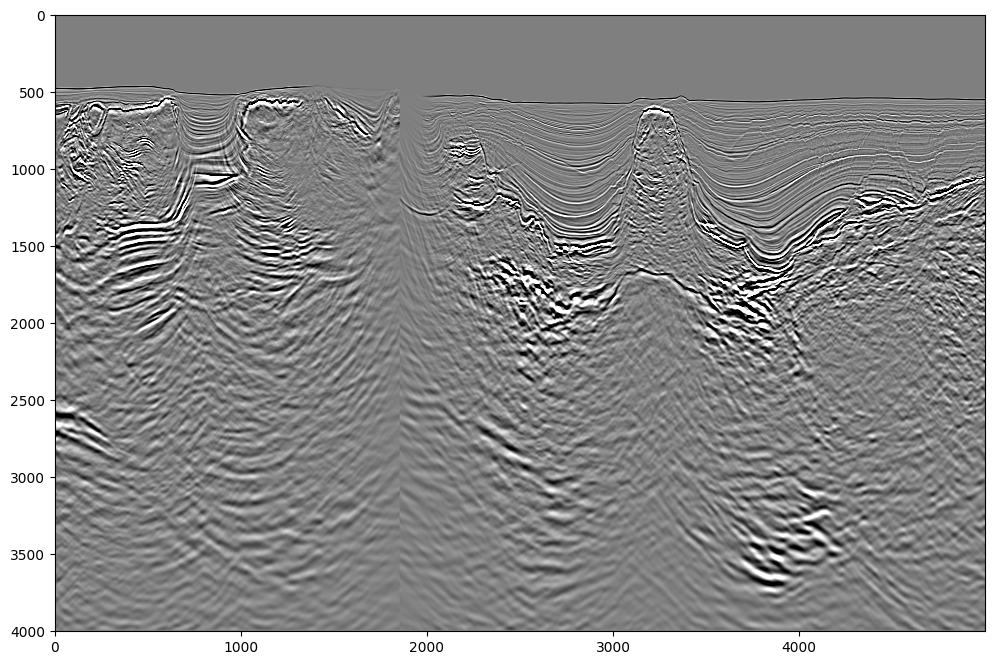

In [9]:
plt.figure(figsize=(12, 8))
plot_kw = {"aspect": "auto", "cmap": "gray_r", "interpolation": "bilinear"}
plt.imshow(trace_data.T, vmin=-2, vmax=2, **plot_kw);

# ReDo the Same with Custom Schema

We will create a new custom schema based on SEG-Y revision 1 with different binary
and trace headers. This way we will parse ONLY the parts we want, with correct byte
locations.

A user can define a completely custom SEG-Y schema from scratch as well, but for
convenience, we are customizing Revision 1 schema with the parts that we want to
customize.

Note that doing this will also modify the `segyStandard` field to `"custom"` to
make sure we don't assume the file schema is standard after doing this.

From the binary file header we will read:
- Number of samples
- Sample rate

From the trace headers, we will read:
- Inline
- Crossline
- CDP-X
- CDP-Y
- Water bottom depth
- Coordinate scalar

Based on the text header lines:

```
C35  WATER BOTTOM DEPTH  61-64     4I    CDP X-COORDINATE*100  181-184   4I     
C36  TRACK (INLINE NO)   189-192   4I    CDP Y-COORDINATE*100  185-188   4I     
C37  BIN (CROSSLINE NO)  193-196   4I    SCALAR XY COORD.       71-72    2I     
```

In [11]:
from segy.schema import HeaderFieldDescriptor
from segy.standards import rev1_segy

custom_spec = rev1_segy.customize(
    binary_header_fields=[
        HeaderFieldDescriptor(name="sample_interval", offset=16, format="int16"),
        HeaderFieldDescriptor(name="samples_per_trace", offset=20, format="int16"),
    ],
    trace_header_fields=[
        HeaderFieldDescriptor(name="inline", offset=188, format="int32"),
        HeaderFieldDescriptor(name="crossline", offset=192, format="int32"),
        HeaderFieldDescriptor(name="cdp-x", offset=180, format="int32"),
        HeaderFieldDescriptor(name="cdp-y", offset=184, format="int32"),
        HeaderFieldDescriptor(name="water_bottom_depth", offset=60, format="int32"),
        HeaderFieldDescriptor(name="coordinate_scalar", offset=70, format="int16"),
    ],
)

sgy = SegyFile.from_spec(path, custom_spec)

Now let's look at the JSON for the desciptor again. It is a lot more concise.

In [12]:
JSON(json.loads(sgy.spec.model_dump_json()))

<IPython.core.display.JSON object>

As mentioned earlier, the JSON can be laded into the descriptor from a file too.

```python
from segy.schema.segy import SegyDescriptor
import os

json_path = "..."

with open(json_path, mode="r") as fp:
    data = fp.read()
    spec = SegyDescriptor.model_validate_json(data)
```

Let's do something a little more interesting now. Let's try to plot the water bottom
depth by randomly sampling the file.

We will read 5,000 random traces. This should take about 15 seconds, based on
your internet connection speed.

In [13]:
text_header = sgy.text_header
binary_header = sgy.binary_header

from numpy.random import randint
indices = randint(0, sgy.num_traces, size=5_000).tolist()

traces = sgy.trace[indices]

In [14]:
binary_header

,sample_interval,samples_per_trace
0,5000,4001


In [15]:
trace_headers = traces["header"]

trace_headers["cdp-x"] /= trace_headers["coordinate_scalar"].abs()
trace_headers["cdp-y"] /= trace_headers["coordinate_scalar"].abs()

trace_headers

,inline,crossline,cdp-x,cdp-y,water_bottom_depth,coordinate_scalar
0,8046,12369,575299.56,7019938.0,2616,-100
1,8049,6447,543125.44,7001642.0,2668,-100
2,8052,25569,647093.31,7060582.0,2417,-100
3,8056,13229,580036.31,7022482.0,2622,-100
4,8056,13857,583450.19,7024419.0,2576,-100
...,...,...,...,...,...,...
4995,17082,44721,806903.06,7021471.0,2549,-100
4996,17083,45581,811584.31,7024112.0,2536,-100
4997,17088,34519,751480.88,6989943.0,2449,-100
4998,17089,30213,728079.13,6976652.0,2423,-100


Now we can plot the water bottom depth from the headers, and even see a hint
of the convex hull of the data!

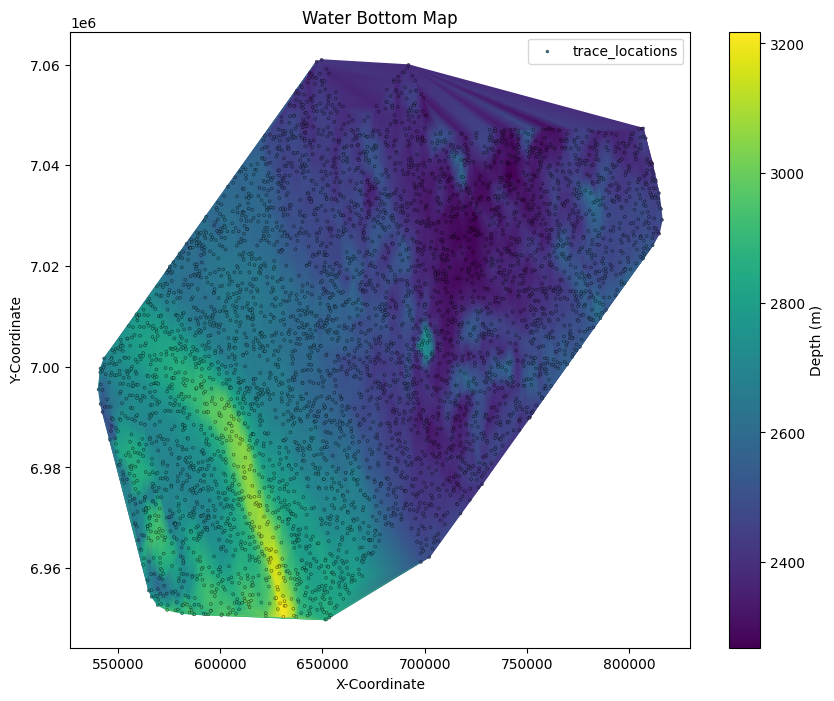

In [16]:
plt.figure(figsize=(10, 8))

x, y, z = trace_headers["cdp-x"], trace_headers["cdp-y"], trace_headers["water_bottom_depth"]

black_rgba = [0., 0., 0., 0.5]
plt.tripcolor(x, y, z, shading="gouraud")
plt.scatter(x, y, s=4, c=z, ec=black_rgba, linewidth=0.5, label="trace_locations")
plt.title("Water Bottom Map")
plt.colorbar(label="Depth (m)")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.legend();